In [ ]:
# !pip install Levenshtein

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import Levenshtein

from morse.models import MySomething
from morse.my_datasets import ListDataset, load_tensors, filenames_to_torch
from morse.samplers import LongCTCSampler
from morse.augmentations import rotation_transform
from morse.text_helpers import Vectorizer

In [3]:
dev_flag = True

data_dir = 'data/melspec_nfft512_nc64'
labels_dir = ''

In [4]:
full_train_df = pd.read_csv(Path(labels_dir, 'train.csv'))
test_df = pd.read_csv(Path(labels_dir, 'test.csv'))
full_train_df.head()

,id,message
0,1.opus,03ЩУЫЛПИГХ
1,2.opus,ЪЛТ0ДС6А3Г
2,3.opus,5ЭКЫБЗХЯН
3,4.opus,ЖЫЦОИ68КФ
4,5.opus,32Ю7МЫ ЗЛ


In [20]:
index_to_letter = sorted(set(''.join(full_train_df['message'])))
pad_value = 0
print(index_to_letter)
letter_to_index = dict([(letter, i) for i, letter in enumerate(index_to_letter)])
dictionary_size = len(index_to_letter)
print(dictionary_size)
print(letter_to_index)

vectorizer = Vectorizer(letter_to_index, index_to_letter)
print(vectorizer.text_transform('ПРИВЕТ #'))

[' ', '#', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я']
44
{' ': 0, '#': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, 'А': 12, 'Б': 13, 'В': 14, 'Г': 15, 'Д': 16, 'Е': 17, 'Ж': 18, 'З': 19, 'И': 20, 'Й': 21, 'К': 22, 'Л': 23, 'М': 24, 'Н': 25, 'О': 26, 'П': 27, 'Р': 28, 'С': 29, 'Т': 30, 'У': 31, 'Ф': 32, 'Х': 33, 'Ц': 34, 'Ч': 35, 'Ш': 36, 'Щ': 37, 'Ъ': 38, 'Ы': 39, 'Ь': 40, 'Э': 41, 'Ю': 42, 'Я': 43}
tensor([27, 28, 20, 14, 17, 30,  0,  1])


(3000,) (5000,)


3000it [00:20, 149.83it/s]
5000it [00:32, 154.74it/s]


3000 5000
МЪА П0ЪЛ


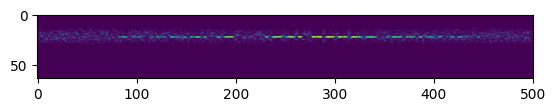

In [17]:
train_index, val_index = train_test_split(np.arange(full_train_df.shape[0]), test_size=1/6, shuffle=True, 
                                           random_state=42)
if dev_flag:
    train_index = train_index[:3000]    # to save memory

print(train_index.shape, val_index.shape)

train_features = list(tqdm(load_tensors(data_dir, filenames_to_torch(list(full_train_df.iloc[train_index]['id'])))))
val_features = list(tqdm(load_tensors(data_dir, filenames_to_torch(list(full_train_df.iloc[val_index]['id'])))))
train_labels = list(full_train_df.iloc[train_index]['message'])
val_labels = list(full_train_df.iloc[val_index]['message'])

assert len(train_features) == len(train_labels)
assert len(val_features) == len(val_labels)

trainset = ListDataset(train_features, train_labels, transform=rotation_transform)
valset = ListDataset(val_features, val_labels)

print(len(trainset), len(valset))
plt.imshow(valset[0][0])
print(valset[0][1])

In [21]:
vectorizer.batch_text_transform(val_labels[:10], pad_value=pad_value)

(tensor([[24, 38, 12,  0, 27,  2, 38, 23,  0,  0,  0,  0,  0],
         [25,  7,  1, 18,  4, 29, 10, 22, 15,  0,  0,  0,  0],
         [24, 40,  2, 42, 40,  0, 36, 35, 23, 25,  0,  0,  0],
         [26, 15,  3,  0, 23, 17, 17, 13, 33, 20, 17, 37,  0],
         [ 5, 18, 27,  4, 27, 20,  7, 39,  0,  0,  0,  0,  0],
         [32,  0, 33, 30, 13, 38,  1, 23, 30, 24, 20, 28, 27],
         [36,  6,  2, 35,  0, 39, 21, 14, 43, 15,  0,  0,  0],
         [11,  0,  3, 14, 37, 33,  0, 38,  0,  0,  0,  0,  0],
         [28, 42,  0, 19,  0, 15, 40, 26,  0, 16, 34,  0,  0],
         [19,  0, 25, 17, 19, 29, 22, 12,  1, 25, 40, 31, 28]]),
 tensor([ 8,  9, 10, 12,  8, 13, 10,  8, 11, 13]))

# train

In [22]:
device = 0 if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [29]:
def batch_text_transform(texts):
    vecs, lengths = vectorizer.batch_text_transform(texts, pad_value=pad_value)
    return vecs + 1, lengths

In [30]:
n_epochs = 90


n_pooled_blocks = 4
n_head_blocks = 2
batch_size = 128
lr = 0.005
# n_blocks = 12
inner_size = 64
# exp_gamma = 0.8
step_gamma = 0.359
p_dropout = 0.165
pooled_blocks_thickness = 3

group = 'mySomething'
run_name = 'refactored_code_in_need_of_testing'

config = {
    'n_epochs': n_epochs,
    'batch_size': batch_size,
    'lr': lr,
    # 'n_blocks': n_blocks,
    'n_pooled_blocks': n_pooled_blocks,
    'n_head_blocks': n_head_blocks,
    'inner_size': inner_size,
    # 'exp_gamma': exp_gamma,
    'step_gamma': step_gamma,
    'p_dropout': p_dropout,
}

In [33]:
model = MySomething(n_pooled_blocks = n_pooled_blocks, n_head_blocks = n_head_blocks, 
                    pooled_blocks_thickness = pooled_blocks_thickness,
                    input_size = 64, inner_size = inner_size, output_size = dictionary_size + 1,
                    p_dropout = p_dropout).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=step_gamma)
ctc_loss = nn.CTCLoss()


train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)


# with wandb.init(
#         **common_wandb_kvals,
#         group=group,
#         config=config,
#         name=run_name,
#         ) as run:
for epoch in range(n_epochs):
    model.train()
    train_loss_buffer = []
    for features, labels in tqdm(train_loader):
        features = features.to(device)
        targets, target_lengths = batch_text_transform(labels)
        targets, target_lengths = targets.to(device), target_lengths.to(torch.int32).to(device)
        outs = model(features).transpose(0, 2).transpose(1, 2)
        inputs = F.log_softmax(outs, dim=2)
        input_lengths = torch.full(size=(inputs.shape[1],), fill_value=inputs.shape[0], dtype=torch.int32).to(device)
        loss = ctc_loss(inputs, targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_buffer.append(loss.detach())
    scheduler.step()
    model.eval()
    test_loss_buffer = []
    with torch.no_grad():
        for features, labels in tqdm(val_loader):
            features = features.to(device)
            targets, target_lengths = batch_text_transform(labels)
            targets, target_lengths = targets.to(device), target_lengths.to(torch.int32).to(device)
            outs = model(features).transpose(0, 2).transpose(1, 2)
            inputs = F.log_softmax(outs, dim=2)
            input_lengths = torch.full(size=(inputs.shape[1],), fill_value=inputs.shape[0], dtype=torch.int32).to(device)
            loss = ctc_loss(inputs, targets, input_lengths, target_lengths)
            test_loss_buffer.append(loss.detach())
    train_loss_value = torch.mean(torch.stack(train_loss_buffer)).item()
    test_loss_value = torch.mean(torch.stack(test_loss_buffer)).item()
    print('train: ', train_loss_value)
    print('test:  ', test_loss_value)
        # wandb.log({
        #     'train_loss': train_loss_value,
        #     'test_loss': test_loss_value,
        #     'lr': scheduler.get_last_lr()[0],
        # })

  0%|          | 0/24 [00:00<?, ?it/s]

 52%|█████▎    | 21/40 [00:05<00:04,  4.00it/s]


KeyboardInterrupt: 

# val metric

In [36]:
model.eval()
with torch.no_grad():
    distance_buffer = []
    for features, labels in tqdm([valset[i] for i in range(1000)]):
        features = features.to(device)
        outs = model(features[None]).squeeze().to('cpu')
        probs = F.softmax(outs, dim=0)
        seqs, likelihood = LongCTCSampler.sample(probs, beam_size=10)
        text = vectorizer.from_tensor(torch.tensor(seqs) - 1)
        decoded_message = text
        dist = Levenshtein.distance(decoded_message, labels)
        distance_buffer.append(dist)
    mean_dist = np.mean(distance_buffer)
mean_dist

  0%|          | 2/1000 [00:00<02:06,  7.88it/s]e:\dev\ML\morse\src\morse\samplers.py:53: RuntimeWarning: divide by zero encountered in log
  probs = np.log(probs)
100%|██████████| 1000/1000 [01:12<00:00, 13.87it/s]


np.float64(8.769)

# inference

У5БП Ю9В


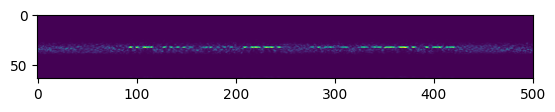

(26,)
Н


In [37]:
model.eval()
with torch.no_grad():
    features, labels = valset[392]
    print(labels)
    plt.imshow(features)
    plt.show()
    features = features.to(device)
    outs = model(features[None]).squeeze().to('cpu')
    probs = F.softmax(outs, dim=0)
    seqs, likelihood = LongCTCSampler.sample(probs, beam_size=10)
    print(seqs)
    text = vectorizer.from_tensor(torch.tensor(seqs) - 1)
    print(text)
    